# Scaled damage GUTS model

The scaled damage guts model is fitted to internal concentrations and survival data and models damage as a scaled quantity with a fixed rate constant.

## Imports

First, I apply some modifications to the jupyter notebook for a cleaner experience.
Warnigns are ignored, the root directory is changed to the base of the repository.
Then relevant packages are imported for the case study and its evaluation

In [1]:
import os
import json
import warnings
from functools import partial

import numpy as np
import arviz as az
import matplotlib as mpl
from matplotlib import pyplot as plt

from pymob.utils.store_file import prepare_casestudy

warnings.filterwarnings("ignore")

# change the directory to the root of where the case studies are located.
# see https://pymob.readthedocs.io/en/latest/simulation.html#simulation-components
os.chdir("/home/flo-schu/projects/damage-proxy")

In [9]:
config = prepare_casestudy(
    case_study=("guts", "guts_scaled_damage"),
    config_file="settings.cfg",
)

# import simulation, ODE model and probability model
from case_studies.guts.sim import SingleSubstanceSim2
from case_studies.guts.prob import model_guts_scaled_damage
from case_studies.guts.mod import tktd_guts_scaled_damage

In [10]:
# Knapp data are IDs 37, 38, 39
sim = SingleSubstanceSim2(config=config)
sim.model = tktd_guts_scaled_damage

MinMaxScaler(variable=cext, min=0.0, max=514.382187237679)
MinMaxScaler(variable=cint, min=0.0, max=6364.836264471382)
MinMaxScaler(variable=survival, min=0.0, max=18.0)


## Parameter inference

Parameter inference estimates the value of the parameters given the data 
presented to the model.

Here we calculate a maximum a posteriori (MAP) estimate which is the mode
of the posterior distribution.

In [11]:
# set up the inferer properly
sim.set_inferer("numpyro")


First of all prior predictions are generated. These are helpful to diagnose
the model and also to compare posterior parameter estimates with the prior
distributions. If there is a large bias, this information can help to achieve
a better model fit. We can speed up the prior predictive sampling, if we let
the model only sample the prior distributions `only_prior=True`

In [12]:
# set the inference model
sim.inferer.inference_model = partial(model_guts_scaled_damage, only_prior=True)
sim.coordinates["time"] = sim.observations.time.values

# prior predictions
seed = int(np.random.random_integers(0, 100, 1))
prior_predictions = sim.inferer.prior_predictions(n=4000, seed=seed)

In the next step, we take the full model, including deterministic ODE solution
and error model and run our MAP estimator on it, with the parameters that have
been setup before.

       Trace Shapes:         
        Param Sites:         
       Sample Sites:         
       k_i_norm dist      3 |
               value      3 |
       k_e_norm dist      3 |
               value      3 |
       k_d_norm dist      3 |
               value      3 |
         z_norm dist      3 |
               value      3 |
       h_b_norm dist      3 |
               value      3 |
        kk_norm dist      3 |
               value      3 |
sigma_cint_norm dist      3 |
               value      3 |
       cint_obs dist 202 23 |
               value 202 23 |
   survival_obs dist 202 23 |
               value 202 23 |


100%|██████████| 5000/5000 [00:57<00:00, 86.27it/s, init loss: 11015.2119, avg. loss [4751-5000]: 2776.1333] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)


                  mean  sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
h_b[0]           0.007 NaN    0.007    0.007        NaN      NaN       NaN   
h_b[1]           0.000 NaN    0.000    0.000        NaN      NaN       NaN   
h_b[2]           0.000 NaN    0.000    0.000        NaN      NaN       NaN   
k_d[0]           0.001 NaN    0.001    0.001        NaN      NaN       NaN   
k_d[1]           0.013 NaN    0.013    0.013        NaN      NaN       NaN   
k_d[2]           0.001 NaN    0.001    0.001        NaN      NaN       NaN   
k_e[0]           0.526 NaN    0.526    0.526        NaN      NaN       NaN   
k_e[1]           0.674 NaN    0.674    0.674        NaN      NaN       NaN   
k_e[2]           0.077 NaN    0.077    0.077        NaN      NaN       NaN   
k_i[0]          10.806 NaN   10.806   10.806        NaN      NaN       NaN   
k_i[1]           3.220 NaN    3.220    3.220        NaN      NaN       NaN   
k_i[2]           0.647 NaN    0.647    0.647        NaN      NaN

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

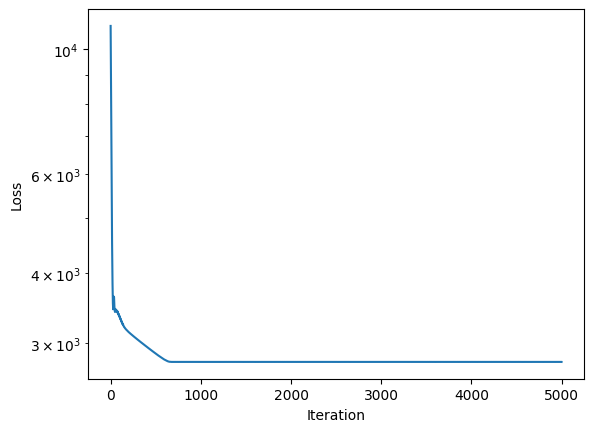

In [13]:
# set the inference model
sim.config.set("inference.numpyro", "kernel", "svi")
sim.config.set("inference.numpyro", "svi_iterations", "5000")
sim.config.set("inference.numpyro", "svi_learning_rate", "0.01")
sim.coordinates["time"] = sim.observations.time.values
sim.inferer.inference_model = partial(model_guts_scaled_damage, only_prior=False)
sim.inferer.run()

# show (and explore idata)
sim.inferer.idata

## Posterior predictions

In order to evaluate the goodness of fit for the posteriors, we are looking
at the posterior predictions.

In order to obtain smoother trajectories, the time resolution is increased,
and posterior predictions are calculated.

In [14]:
sim.coordinates["time"] = np.linspace(24, 120, 100)
sim.config.set("inference", "n_predictions", "1")
seed = int(np.random.random_integers(0, 100, 1))

res = sim.inferer.posterior_predictions(n=1, seed=seed).mean(("draw", "chain"))
res

Posterior predictions:   0%|          | 0/1 [00:00<?, ?it/s]

Posterior predictions: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


<xarray.Dataset>
Dimensions:    (id: 202, time: 100)
Coordinates:
  * id         (id) object '101_0' '101_1' '106_0' ... '66_4' '66_5' '6_0'
  * time       (time) float64 24.0 24.97 25.94 26.91 ... 117.1 118.1 119.0 120.0
Data variables:
    D          (id, time) float32 0.0 0.01136 0.03912 ... 237.8 240.5 243.2
    cext       (id, time) float32 2.34 2.34 2.34 2.34 ... 349.5 349.5 349.5
    cint       (id, time) float32 0.0 19.21 30.73 ... 2.951e+03 2.951e+03
    lethality  (id, time) float32 0.0 0.006853 0.01366 ... 0.9853 0.9878 0.99
    survival   (id, time) float32 1.0 0.9931 0.9863 ... 0.01474 0.01216 0.009992

Next, we plot the predictions against selected experiments. Note that the observations,
may be slightly diverging from the MAP predictions, because
a) the model is not completely correct
b) other data *pull* the posterior estimate away from the displayed data.

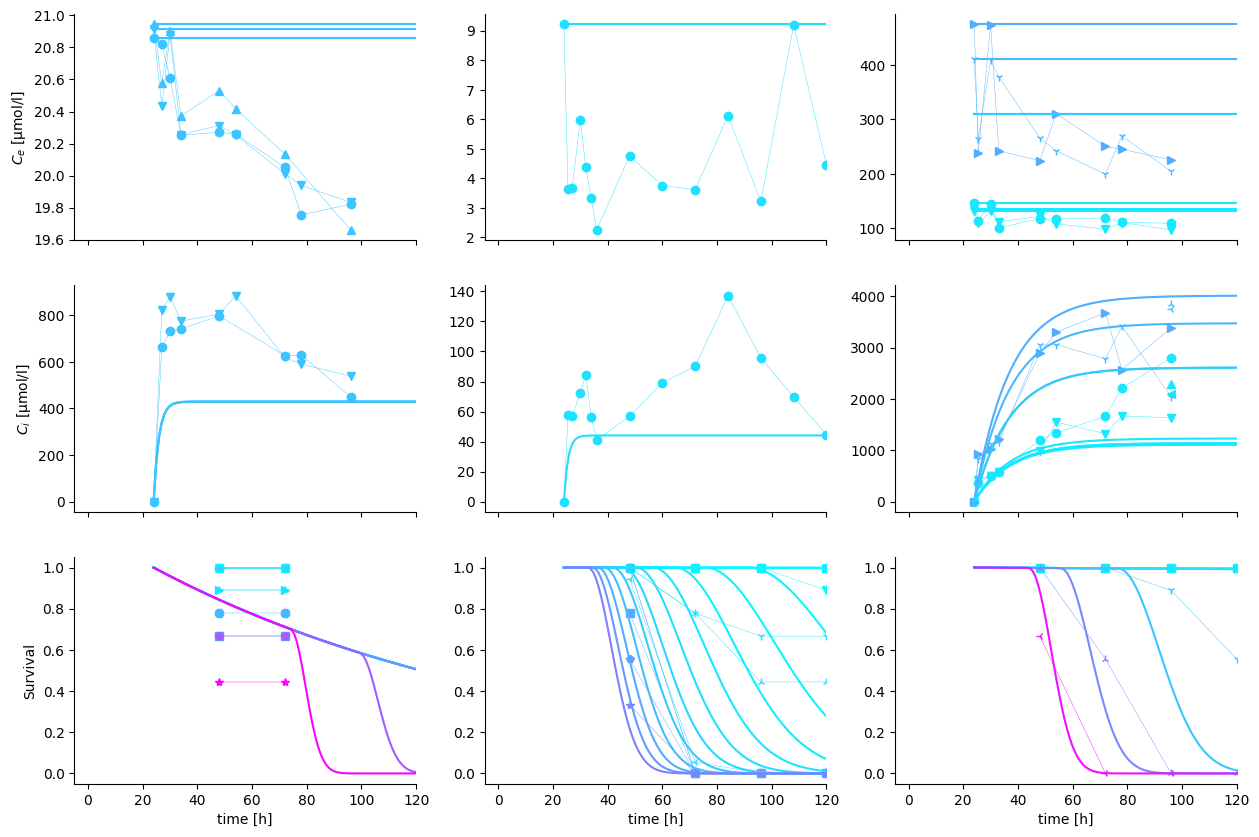

In [16]:
with open(sim.scenario_path + "/experiment_selection_1.json", "r") as fp:
    data_structure = json.load(fp)
    
res = res.assign_coords({"substance": sim.observations.substance})
cmap = mpl.colormaps["cool"]
fig, axes = plt.subplots(len(data_structure), 3, sharex=True, figsize=(15,10))


for r, (v, vdict) in enumerate(data_structure.items()):
    for c, (s, sdict) in enumerate(vdict["substances"].items()):
        sdata = sim.observations.where(sim.observations.substance == s, drop=True)
        C = np.round(sdata.cext_nom.values, 1)
        norm = mpl.colors.Normalize(vmin=C.min(), vmax=C.max())
        for eid in sdict["experiment_ids"]:

            ax, meta, obs_ids, _ = sim.mplot.plot_experiment(
                self=sim,
                experiment_id=eid,
                substance=s,
                data_var=v,
                cmap=cmap,
                norm=norm,
                ax=axes[r, c]
            )

            if v != "survival":
                ax.set_xlabel("")

            if v == "nrf2":
                ax.set_ylim(0, 4)
                # note that the thresholds are mixed up. Diuron and Diclofenac should swap
                z = sim.inferer.idata.posterior.z.mean(("chain", "draw")).values
                ax.hlines(z[c], -10, 120, color="black", lw=0.5)

            if c != 0:
                ax.set_ylabel("")

            l = ax.get_legend()
            if l is not None:
                l.remove()
            ax.set_title("")

            res_ids = sim.get_ids(res, {"substance": s, "experiment_id": eid})

            for i in res_ids:
                y = res.sel(id=i)
                ax.plot(res.time, y[v], color=cmap(norm(y.cext.isel(time=0))))


In the combined model (tktd_rna_3_1), especially NRF2 of Naproxen converges on an
incorrect model dynamic. This is caused (I'm sure) by the substance-indepdendent
threshold parameter $z$ and killing rate $k_k$

## Compare prior and posterior distributions to diagnose biases

We can also look at the prior distributions and the MAP estimate of the posterior
parameter distribution, to assess, whether we are influencing the fit by 
providing a prior that is very far away from the posterior estimate.

In this case-study, the priors should have only a small effect, because of the
large amount of data. Still it is better to be sure.

Since, the parameters are on vastly different scales, they are displayed on the
log-axis.

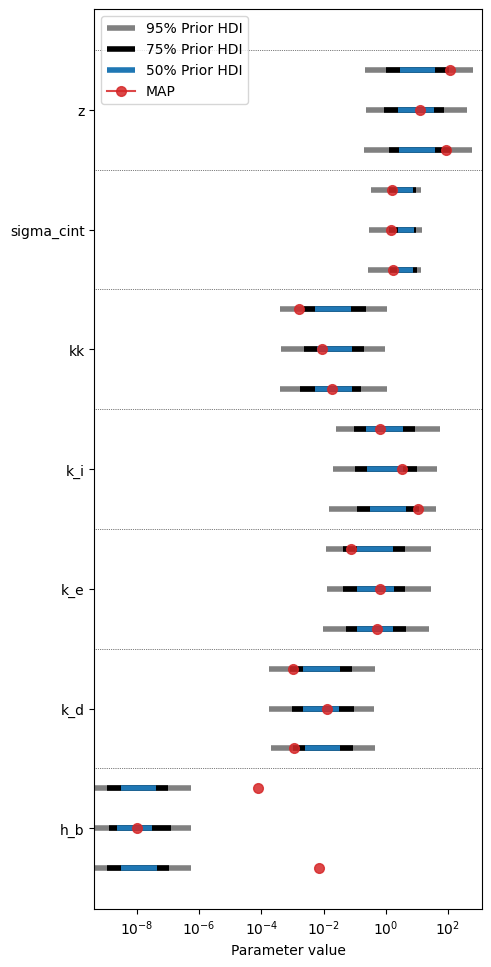

In [17]:
# mpl.use('TkAgg')

substances = sim.observations.attrs["substance"]
priors = prior_predictions.prior.stack(sample=("chain", "draw"))
posteriors = sim.inferer.idata.posterior

hdi_priors_50 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.50))
hdi_priors_75 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.75))
hdi_priors_95 = np.exp(az.hdi(np.log(prior_predictions.prior), hdi_prob=0.95))

fig, ax = plt.subplots(1, 1, figsize=(5, 10))

prior_names = list(priors.data_vars.keys())
xmax = hdi_priors_95.max().to_array().max() * 2
xmin = hdi_priors_95.min().to_array().min() * 2

for k, (key, prior) in enumerate(priors.data_vars.items()):
    nsubstance = len(prior.coords[f"{key}_dim_0"])
    for i in range(nsubstance):
        if nsubstance == 1:
            y = 1
        else:
            y = i

        y_ = k + (y/3 - 1/3)
        h95 = hdi_priors_95[key].isel({f"{key}_dim_0": i})
        h75 = hdi_priors_75[key].isel({f"{key}_dim_0": i})
        h50 = hdi_priors_50[key].isel({f"{key}_dim_0": i})
        posterior_estimate = posteriors[key].mean(("chain", "draw"))
        map_ = posterior_estimate.isel({f"{key}_dim_0": i})

        ax.hlines(y_, *h95, lw=4, color="grey")
        ax.hlines(y_, *h75, lw=4, color="black")
        ax.hlines(y_, *h50, lw=4, color="tab:blue")
        ax.plot(map_, y_, color="tab:red", ms=7, alpha=.85, marker="o")
        if i == 0:
            ax.hlines(k + 0.5, xmin, xmax, ls="dotted", lw=.5, color="black")

ax.set_xscale("log")
ax.set_xlabel("Parameter value")
ax.set_yticks(range(len(prior_names)))
ax.set_yticklabels(prior_names, minor=False)
ax.set_xlim(xmin, xmax)
ax.hlines([], [], [], lw=4, color="grey", label="95% Prior HDI")
ax.hlines([], [], [], lw=4, color="black", label="75% Prior HDI")
ax.hlines([], [], [], lw=4, color="tab:blue", label="50% Prior HDI")
ax.plot([], [], ms=7, alpha=.85, marker="o", color="tab:red", label="MAP")
ax.legend()

fig.subplots_adjust(top=0.95, bottom=0.05)
fig.savefig(f"{sim.output_path}/prior_posterior.png")